In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import calendar

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import extract
from sqlalchemy import and_, func


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
#Inspect engine
inspector = inspect(engine)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

#Inspecting Measurement data
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#Inspecting Station data

inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

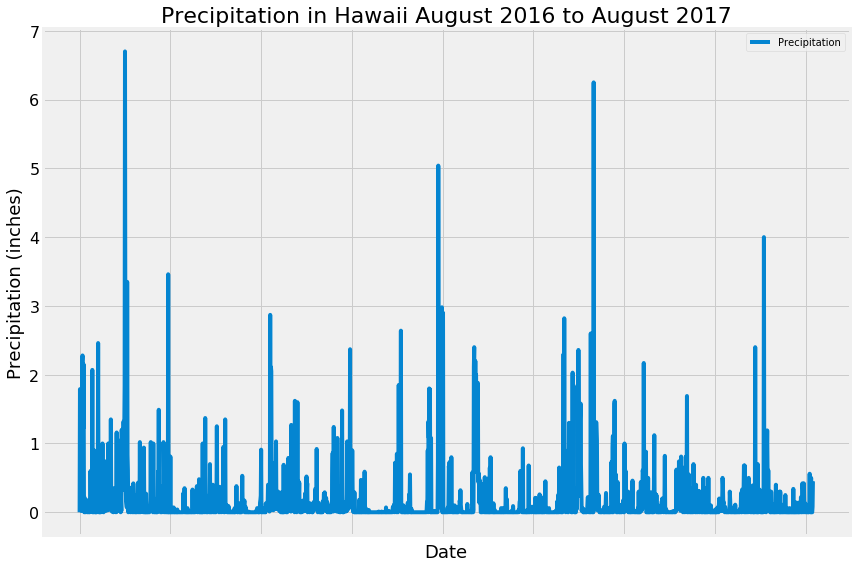

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results 
# Calculate the date 1 year ago from the last data point in the database

#Finding the last data point - 2017-08-23
results = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

#Change date format
latest_day = dt.date(2017,8,23)

#Fiding second value for query
year_ago = latest_day - dt.timedelta(days=365)

#Building query
precipitation = session.query(Measurement.date, Measurement.prcp).filter(and_(func.date(Measurement.date) >= year_ago),\
                                              func.date(Measurement.date) <= latest_day).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(precipitation, columns=['date', 'prcp'])
df.set_index('date', inplace=True,)

# Sort the dataframe by date
df.sort_values("date", inplace=True)

#Dropping NA Values and renaming columns
df = df.dropna(axis=0, how='all')
df = df.rename(columns = {'date':"Date",'prcp':"Precipitation"})
df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(12, 8),                                               
    legend=True,
    fontsize=16,
    grid=True,
    color='xkcd:cerulean')

plt.title ('Precipitation in Hawaii August 2016 to August 2017', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Precipitation (inches)', fontsize=18)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.station, Station.name).count()

print(stations)


9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order

active_stations = session.query(Measurement.station,func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations   

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#Query for all functions
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

stations_temperature = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.tobs).all()

stations_temperature

[(54.0, 85.0, 71.66378066378067)]

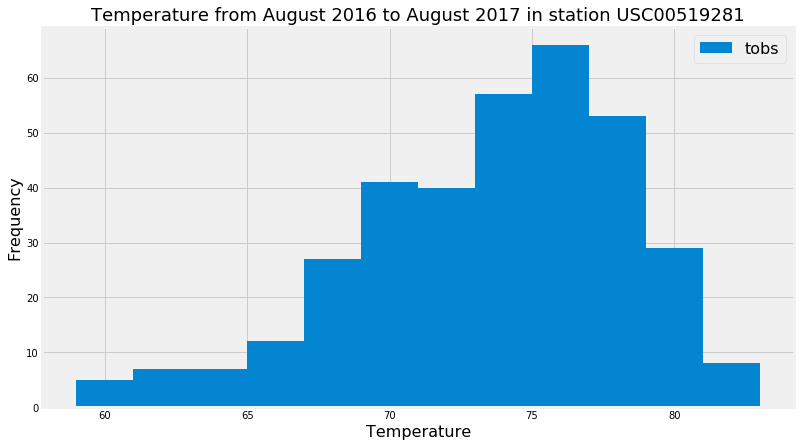

In [16]:
# Choose the station with the highest number of temperature observations.

#ID for most active station
most_active = active_stations[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature = session.query(Measurement.tobs).\
    filter(and_(func.date(Measurement.date) >= year_ago),func.date(Measurement.date) <= latest_day).\
    filter(Measurement.station == most_active).all()
                                                     
most_active_t = list(np.ravel(temperature))

title = f"Temperature from August 2016 to August 2017 in station {most_active}"

#Plotting Data

plt.figure(figsize=(12,7))
plt.hist(most_active_t, bins=12, color='xkcd:cerulean')                          
plt.title(title, fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Temperature', fontsize=16)
labels = ['tobs']
plt.legend(labels, fontsize=16)
plt.show()


In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#trip dates
trip_start_dt = dt.date(2017, 9, 1)
trip_end_dt = dt.date(2017, 9, 15)

temp_avg = (calc_temps((trip_start_dt-dt.timedelta(days=365)), (trip_end_dt-dt.timedelta(days=365))))
print(temp_avg)

[(71.0, 77.58064516129032, 84.0)]


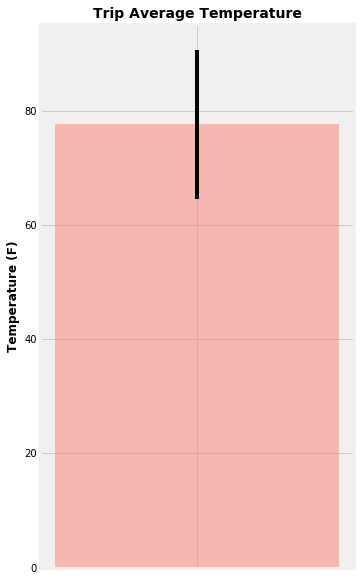

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg = temp_avg[0][1]
tmax = temp_avg[0][2]
tmin = temp_avg[0][0]
yerr = tmax-tmin

plt.figure(figsize=(5,10))                                                    
plt.bar(1, avg, yerr=yerr, tick_label='', color='salmon', alpha=0.5)
plt.ylabel("Temperature (F)", weight="bold")
plt.title("Trip Average Temperature", weight="bold", fontsize=14)
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start_dt = dt.date(2017, 9, 1)
trip_end_dt = dt.date(2017, 9, 15)

#Create previous year start and end date
last_year_sdt =trip_start_dt-dt.timedelta(days=365)
last_year_edt =trip_end_dt-dt.timedelta(days=365)

#creatin
rain_info = [Measurement.station, 
       Station.name, 
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

rainfall = session.query(*rain_info).\
filter(Measurement.station == Station.station, Measurement.date >= last_year_sdt, Measurement.date <= last_year_edt).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

#Create dataframe
df = pd.DataFrame(rainfall, columns=['Station ID', 'Station Name','Latitude','Longitude','Elevation','Precipitation'])
df.set_index('Station ID', inplace=True,)

df.head(7)

,Station Name,Latitude,Longitude,Elevation,Precipitation
Station ID,,,,,
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,18.56
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,5.02
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,3.45
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.99
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.23
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.92
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# Set the start and end date of the trip
#SET ABOVE 

# Use the start and end date to create a range of dates
trip_2017 = pd.date_range(trip_start_dt, trip_end_dt)

#format it to %m-%d
trip_d = trip_2017.strftime('%m-%d')

# calculate the daily normals for your trip
normal = []
for dates in trip_d:
        normal.append(*daily_normals(dates))
        
# Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
df_trip = pd.DataFrame(normal, columns=['Min Temp', 'Avg Temp','Max Temp'])
df_trip["Date"] = trip_2017
df_trip = df_trip.set_index('Date')

df_trip

,Min Temp,Avg Temp,Max Temp
Date,,,
2017-09-01,69.0,77.000000,82.0
2017-09-02,67.0,76.666667,83.0
2017-09-03,69.0,76.137255,83.0
2017-09-04,68.0,76.270833,84.0
2017-09-05,66.0,75.914894,84.0
2017-09-06,66.0,74.911111,81.0
2017-09-07,64.0,75.180000,82.0
2017-09-08,66.0,76.222222,83.0
2017-09-09,68.0,76.365385,84.0


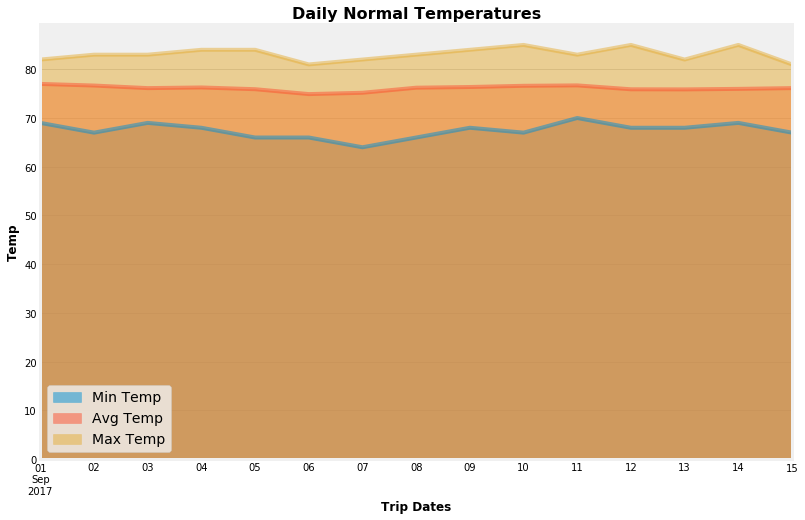

In [23]:
# Use Pandas to plot an area plot (stacked=False) for the daily normals.
ax = df_trip.plot(kind='area',figsize=(12, 8), stacked=False)

plt.xlabel('Trip Dates',weight="bold")
plt.ylabel('Temp', weight="bold")
plt.title('Daily Normal Temperatures', weight='bold', fontsize=16)
plt.legend(fontsize=14)
ax.margins(0, 0)
plt.show()
